### Social Media Agentic Team

Experiment with an agentic team of social media agents. Given a topic / social media post idea, multiple agents will kick off to generate content for specific social media platforms.

In [1]:
import os 
import sys
sys.path.append('..')

from dotenv import load_dotenv
load_dotenv()

from IPython.display import display, Markdown, Image
import base64

from utils.llm import chat_completion

from openai import OpenAI
client = OpenAI()

from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, END, StateGraph

from pydantic import BaseModel, Field
from typing import Annotated, Sequence, TypedDict, List, Dict
import json

### Create tools for each agent

#### 1. Image generation

In [2]:
# name image - when saving, we will ask AI to name the image

def name_image(image_prompt: str):

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You assist with naming images. Given an image prompt, you will return a name for the image to save it to a png. Do not add the extension to the name."},
            {"role": "user", "content": image_prompt}
        ]
    )

    generated_name = completion.choices[0].message.content
    print(f'Generated name: {generated_name}')

    return generated_name

# generate image

def generate_image(image_prompt: str):

    response = client.images.generate(
        model="dall-e-3",
        prompt=image_prompt,
        size="1024x1024",
        quality="hd",
        style="vivid",
        n=1,
        response_format = "b64_json" #url
    )

    revised_prompt = response.data[0].revised_prompt
    #url = response.data[0].url
    base64_image = response.data[0].b64_json

    print(f'Successfully generated image')

    return revised_prompt, base64_image

# save image

def save_image(image_name: str, base64_image: str):

    img_data = base64.b64decode(base64_image)
    path = f"social_media_agentic_team_temp/{image_name}.png"

    with open(path, "wb") as f:
        f.write(img_data)

    print(f'Successfully saved image to {path}')

    return path

# image tool

@tool
def image_generation_tool(image_prompt: str):

    """
    Generate an image given a description.
    """

    revised_prompt, base64_image = generate_image(image_prompt)
    image_name = name_image(revised_prompt)
    path = save_image(image_name, base64_image)

    return f"Image generated and saved to {path}"

Test `DALL-E-3` image generation.

In [3]:
image_prompt = "Never before seen demand for GPUs"
image_generation_tool(image_prompt)

/var/folders/lh/3twyh2mn2mnbfn9wvxvwyb3w0000gp/T/ipykernel_58462/3396530320.py:2: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use invoke instead.
  image_generation_tool(image_prompt)


Successfully generated image
Generated name: GPU_Release_Event_Surge
Successfully saved image to social_media_agentic_team_temp/GPU_Release_Event_Surge.png


'Image generated and saved to social_media_agentic_team_temp/GPU_Release_Event_Surge.png'

In [4]:
path = 'social_media_agentic_team_temp/GPU_Release_Event_Surge.png'

markdown_text = f"""

## Test Markdown with Image

Here is the image:

<img src="{path}" width="450"/>

End of test markdown.
"""

display(Markdown(markdown_text))




## Test Markdown with Image

Here is the image:

<img src="social_media_agentic_team_temp/GPU_Release_Event_Surge.png" width="450"/>

End of test markdown.


#### 2. Perplexity AI Research

In [5]:
model_name_pplx = "llama-3.1-sonar-large-128k-online"
pplx_client = OpenAI(api_key=os.getenv('PPLX_API_KEY'), base_url="https://api.perplexity.ai")
temperature = 0.0
system_msg_pplx = "You are an expert social media content creator. You provide helpful, professional advice to the user."

def perplexity_research(user_message: str):

    print(f'Perplexity research tool called with message: {user_message}')

    response_pplx = chat_completion(
            messages=[
                {"role": "system", "content": system_msg_pplx},
            {"role": "user", "content": user_message}
        ],
        model_name=model_name_pplx,
        temperature=temperature,
        client=pplx_client
    )

    response = response_pplx.choices[0].message.content
    citations = response_pplx.citations

    return response, citations

@tool
def perplexity_research_tool(user_message: str):
    """
    Use Perplexity AI to research a topic.
    """
    response, citations = perplexity_research(user_message)
    pplx_output = f"Insights from Perplexity AI:\n\n{response}\n\nCitations:\n{citations}"

    return pplx_output

Test perplexity research tool

In [6]:
pplx_research_question = "Who is most likely to compete with Nvidia in the GPU market?"
pplx_test_output = perplexity_research_tool(pplx_research_question)

display(Markdown(pplx_test_output))

Perplexity research tool called with message: Who is most likely to compete with Nvidia in the GPU market?


Insights from Perplexity AI:

In the GPU market, the primary competitors to Nvidia are:

## Advanced Micro Devices (AMD)
AMD is Nvidia's most significant and long-standing competitor in the GPU market. AMD offers cost-effective graphics cards, such as its Radeon series, which compete directly with Nvidia's products in terms of performance and price. Despite Nvidia's dominant market share, AMD has managed to carve out a considerable portion of the market and has seen recent successes with big orders from companies like Microsoft, Meta, and OpenAI[1][2][4].

## Intel
Intel, although newer to the GPU market, is also a notable competitor. Intel has launched its Xe Graphics and ARC GPUs, leveraging its expertise in integrated circuits to develop competitive GPU offerings. However, Intel's current market share in the GPU sector is minimal, and it faces significant challenges in gaining traction against Nvidia and AMD[1][2][3].

Other companies, such as Sapphire Technology, Qualcomm, and Broadcom, also play roles in the broader semiconductor and GPU markets, but they are not as directly competitive with Nvidia in the high-performance GPU segment as AMD and Intel are.

### Market Share Dynamics
- Nvidia currently holds around 88-90% of the GPU market share, with AMD's share declining to around 12% and Intel's share being negligible[3][5].
- Despite the dominance of Nvidia, analysts believe there is still room for AMD to compete, particularly in the mid-range segment, and for Intel to potentially make an impact with future GPU releases[1][3][4].

Citations:
['https://www.nerdwallet.com/article/investing/nvidia-competitors', 'https://www.cheddarflow.com/blog/exploring-the-top-nvidia-competitors-in-2023/', 'https://www.techradar.com/computing/gpu/nvidia-now-owns-88-of-the-gpu-market-but-that-might-not-be-a-bad-thing-yet', 'https://fortune.com/2024/07/02/nvidia-competition-ai-chip-gpu-startups-analysts/', 'https://www.techpowerup.com/forums/threads/nvidias-gpu-market-share-hits-90-in-q4-2024-gets-closer-to-full-monopoly.329842/']

In [7]:
tools = [image_generation_tool, perplexity_research_tool]
tool_node = ToolNode(tools)

tools_dict = {tool.name: tool for tool in tools}
tools_str = ", ".join([tool.name for tool in tools])
print(tools_str)

image_generation_tool, perplexity_research_tool


### 2. Prompts

In [8]:
planning_system_msg = "You are an expert social media content creator. You provide helpful, professional advice to the user. You are given a topic and a social media platform. You will provide a plan for the content to be created."

planning_instruction = """
The user wants to create a post about the following topic: 
<topic>{topic}</topic>.

The selected social media platform is: 
<platform>{platform}</platform>.

Background information about the user and the audience: 
<background_info>{background_info}</background_info>.

Return a plan for the content to be created. You can use the following tools:
<tools>{tools}</tools>.

Make sure to only generate one image.
"""

creation_system_msg = "You are an expert social media content creator. You are given tools and a plan for the content to be created. Using your expertise and reasoning, you will create the content."

creation_instruction = """
The user wants to create a post about the following topic: 
<topic>{topic}</topic>.

The selected social media platform is: 
<platform>{platform}</platform>.

Background information about the user and the audience: 
<background_info>{background_info}</background_info>.

You have been provided with the following tools:
<tools>{tools}</tools>.

Once you've done your research, called the necessary tools generate and return with the content. Remember, your content is a social media post. For the visual content (images), embed the image path like you would in markdown, but set the width to 450px.

Example to include image in markdown:
<img src="folder/name.png" width="450"/>

Remember to follow the plan and adhere to the instructions given.
"""

### 3. Structured Outputs

In [9]:
class SocialMediaPostStep(BaseModel):
    step_number: int = Field(description="The number of the step")
    step_description: str = Field(description="A description of the step")
    step_reasoning: str = Field(description="The reasoning behind the step")
    step_tool: str = Field(description="The tool to be used for the step")

class SocialMediaPostPlan(BaseModel):
    steps: List[SocialMediaPostStep] = Field(description="The steps to create the social media post")

### 4. LLMs

In [10]:
planner_model = "gpt-4o-2024-11-20"
content_creator_model = "gpt-4o-2024-11-20"

planner_llm = ChatOpenAI(model=planner_model, temperature=0.0).with_structured_output(SocialMediaPostPlan, method="json_schema", include_raw=True)
content_creator_llm = ChatOpenAI(model=content_creator_model, temperature=0.0).bind_tools(tools)

### 5. Constructing the Graph

1. Construct graph at social media platform levle
2. Connect graphs to metagraph

In [11]:
class SubGraph(TypedDict):

    topic: str
    platform: str
    background_info: str
    
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [12]:

def planner_node(state: SubGraph):

    print(f'Planning for content-topic: {state["topic"]} for platform: {state["platform"]}')

    system_message = SystemMessage(content=planning_system_msg)
    user_message = planning_instruction.format(
        topic=state["topic"], 
        platform=state["platform"], 
        background_info=state["background_info"], 
        tools=tools_str
        )
    
    response = planner_llm.invoke([system_message] + [user_message])

    return {"messages": [response['raw']]}

def content_creator_node(state: SubGraph):

    print(f'Creating content with tool calling')

    system_message = SystemMessage(content=creation_system_msg)
    user_message = creation_instruction.format(
        topic=state["topic"], 
        platform=state["platform"], 
        background_info=state["background_info"], 
        tools=tools_str
        )
    
    response = content_creator_llm.invoke([system_message] + [user_message] + state["messages"])

    return {"messages": [response]}

def tools_node(state: SubGraph):
    
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_dict[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def should_continue(state: SubGraph):
    
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        return "continue"
    else:
        return "end"

In [13]:
workflow = StateGraph(SubGraph)

workflow.add_node("planner", planner_node)
workflow.add_node("content_creator", content_creator_node)
workflow.add_node("tools", tools_node)

workflow.add_edge(START, "planner")
workflow.add_edge("planner", "content_creator")
workflow.add_edge("tools", "content_creator")

workflow.add_conditional_edges("content_creator", should_continue, {'continue': "tools", 'end': END})

app = workflow.compile()

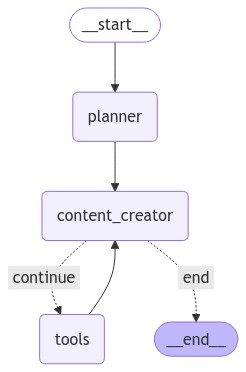

In [14]:
graph_image = app.get_graph().draw_mermaid_png()
with open("../output/social_media_experiment/langgraph_subgraph.png", "wb") as f:
    f.write(graph_image)
display(Image(graph_image))

In [15]:
tester_state = {
    "topic": "Bitcoin's future",
    "platform": "X / Twitter",
    "background_info": "I have just started investing into Bitcoin",
}

test_run = app.invoke(tester_state)

Planning for content-topic: Bitcoin's future for platform: X / Twitter
Creating content with tool calling
Perplexity research tool called with message: What are the current trends and expert opinions on Bitcoin's future?
Creating content with tool calling
Successfully generated image
Generated name: Futuristic_Bitcoin_Radiance
Successfully saved image to social_media_agentic_team_temp/Futuristic_Bitcoin_Radiance.png
Creating content with tool calling


In [16]:
print(test_run['messages'][-1].content)

🚀 As a new Bitcoin investor, I'm excited about its future! Experts predict Bitcoin could hit $200K by 2025, driven by institutional adoption and ETF approvals. 🌟 The journey ahead looks promising, but volatility is part of the game. Are you ready for the ride? #Bitcoin #Crypto

<img src="social_media_agentic_team_temp/Futuristic_Bitcoin_Radiance.png" width="450"/>


In [17]:
display(Markdown(test_run['messages'][-1].content))

🚀 As a new Bitcoin investor, I'm excited about its future! Experts predict Bitcoin could hit $200K by 2025, driven by institutional adoption and ETF approvals. 🌟 The journey ahead looks promising, but volatility is part of the game. Are you ready for the ride? #Bitcoin #Crypto

<img src="social_media_agentic_team_temp/Futuristic_Bitcoin_Radiance.png" width="450"/>

In [18]:
tester_state = {
    "topic": "Upcoming Super Bowl",
    "platform": "X / Twitter",
    "background_info": "Big NFL fan, looking forward to this year's Super Bowl",
}

test_run = app.invoke(tester_state)

display(Markdown(test_run['messages'][-1].content))

Planning for content-topic: Upcoming Super Bowl for platform: X / Twitter
Creating content with tool calling
Perplexity research tool called with message: What are the details of the upcoming Super Bowl, including the date, location, and teams playing?
Creating content with tool calling
Successfully generated image
Generated name: GridironSpectacle_LIX_2025_NewOrleans
Successfully saved image to social_media_agentic_team_temp/GridironSpectacle_LIX_2025_NewOrleans.png
Creating content with tool calling


Here’s the social media post for X / Twitter:

---

🏈 The countdown is on! Super Bowl LIX is happening on **February 9, 2025**, at the iconic **Caesars Superdome** in New Orleans! 🌟

🎤 Halftime show by **Kendrick Lamar**  
🎶 National anthem by **Jon Batiste**  

Who do you think will make it to the big game? Let’s hear your predictions! 🏆🔥  

<img src="social_media_agentic_team_temp/GridironSpectacle_LIX_2025_NewOrleans.png" width="450"/>  

---

This post combines excitement, key details, and a call to action to engage your audience.